In [1]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [2]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from utils import load_data

In [4]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


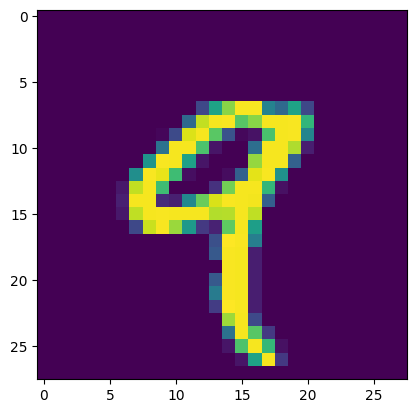

In [5]:
plt.imshow(train_input[4].view((28,28)))
plt.show()

In [6]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [7]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [8]:
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    return 1 - torch.pow(torch.tanh(x), 2)

In [9]:
def loss (v,t):
    return torch.sum(torch.pow(v-t, 2))

def dloss(v,t):
    return 2*(v-t)

In [10]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dloss(v,t)

tensor([[-0.2472,  4.6877,  6.3679, -2.5029, -1.8378,  1.4483],
        [-0.0324, -1.4010, -0.4321, -3.0109, -4.0626, -1.3919],
        [-1.1949, -1.8034,  0.4403, -2.8159,  1.2107, -0.0268]])

In [11]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [12]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [13]:
train_input.shape, train_target.shape

(torch.Size([1000, 784]), torch.Size([1000, 10]))

In [14]:
torch.manual_seed(1337)
w1 = torch.randn(784, 50)
b1 = torch.randn(50)
w2 = torch.randn(50, 10)
b2 = torch.randn(10)
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([784, 50]),
 torch.Size([50]),
 torch.Size([50, 10]),
 torch.Size([10]))

In [15]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1 @ w1 + b1
h1 = sigma(z1)
z2 = h1 @ w2 + b2
h2 = sigma(z2)
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(43.2825, grad_fn=<SumBackward0>))

In [16]:
x1.shape, w1.shape, z1.shape, h1.shape, w2.shape, z2.shape

(torch.Size([5, 784]),
 torch.Size([784, 50]),
 torch.Size([5, 50]),
 torch.Size([5, 50]),
 torch.Size([50, 10]),
 torch.Size([5, 10]))

In [17]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=43.282527923583984


In [18]:
b2.grad.shape

torch.Size([10])

In [19]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0

dh2 = dloss(h2, y1) * dl
cmp('h2',dh2,h2)

dz2 = dsigma(z2) * dh2
cmp('z2',dz2, z2)

dw2 = h1.T @ dz2
cmp('w2',dw2, w2)

db2 = dz2.sum(axis=0, keepdim=True)
cmp('b2',db2, b2)

dh1 = dz2 @ w2.T
cmp('h1',dh1, h1)

dz1 = dsigma(z1) * dh1
cmp('z1', dz1, z1)

dw1 = x1.T @ dz1
cmp('w1', dw1, w1)

db1 = dz1.sum(axis=0, keepdim=True)
cmp('b1', db1, b1)



h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: False | approximate: True  | maxdiff: 1.6298145055770874e-09
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
z1              | exact: False | approximate: True  | maxdiff: 4.423782229423523e-09
w1              | exact: False | approximate: True  | maxdiff: 5.960464477539063e-08
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [20]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [21]:
l = loss(h2, y1)
l.item()

43.282527923583984

##### Now that we've checked our gradients are correct, we can implement the network

In [22]:
def forward(w1, b1, w2, b2, x):
    z1 = x @ w1 + b1
    h1 = sigma(z1)
    z2 = h1 @ w2 + b2
    h2 = sigma(z2)
    return z1, h1, z2, h2


In [23]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2, y1) * dl
    dz2 = dsigma(z2) * dh2
    dw2 = h1.T @ dz2
    db2 = dz2.sum(axis=0, keepdim=True)
    dh1 = dz2 @ w2.T
    dz1 = dsigma(z1) * dh1
    dw1 = x1.T @ dz1
    db1 = dz1.sum(axis=0, keepdim=True)
    return dw1, db1, dw2, db2

In [24]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 += -lr * dw1
        b1 += -lr * db1.squeeze()
        w2 += -lr * dw2
        b2 += -lr * db2.squeeze()
    return w1, b1, w2, b2

In [25]:
eps = 1e-6
def init():
    """ init a network """
    w1 = torch.randn(784, 50) * 1e-6
    b1 = torch.randn(50) * 1e-6
    w2 = torch.randn(50, 10) * 1e-6
    b2 = torch.randn(10) * 1e-6
    return w1, b1, w2, b2

In [26]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [27]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)
        # update
        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [28]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 809.9998779296875
step = 100, loss = 350.6029968261719
step = 200, loss = 247.1372833251953
step = 300, loss = 171.2042236328125
step = 400, loss = 123.42284393310547
step = 500, loss = 102.33448791503906
step = 600, loss = 93.44932556152344
step = 700, loss = 91.25065612792969
step = 800, loss = 102.4915542602539
step = 900, loss = 66.74456024169922
step = 1000, loss = 65.22980499267578
step = 1100, loss = 59.11540985107422
step = 1200, loss = 50.34986877441406
step = 1300, loss = 41.20589828491211
step = 1400, loss = 64.10363006591797
step = 1500, loss = 44.245262145996094
step = 1600, loss = 43.444725036621094
step = 1700, loss = 39.72929382324219
step = 1800, loss = 35.52864456176758
step = 1900, loss = 33.51399612426758
step = 2000, loss = 33.9650993347168
step = 2100, loss = 27.72437286376953
step = 2200, loss = 30.23508644104004
step = 2300, loss = 30.669334411621094
step = 2400, loss = 28.70865249633789
step = 2500, loss = 27.185157775878906
step = 2600, loss =

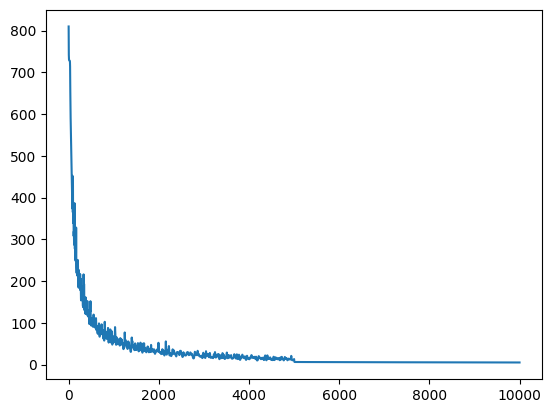

In [29]:
plt.plot(lossi)
plt.show()

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [30]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [31]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [32]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 809.9999389648438
step = 100, loss = 370.45458984375
step = 200, loss = 208.1077423095703
step = 300, loss = 177.03892517089844
step = 400, loss = 153.56793212890625
step = 500, loss = 122.83384704589844
step = 600, loss = 89.76976013183594
step = 700, loss = 81.34873962402344
step = 800, loss = 71.91224670410156
step = 900, loss = 67.92233276367188
step = 1000, loss = 44.64136505126953
step = 1100, loss = 49.95896911621094
step = 1200, loss = 49.49287796020508
step = 1300, loss = 45.80031204223633
step = 1400, loss = 38.6726188659668
step = 1500, loss = 42.00211715698242
step = 1600, loss = 41.42268371582031
step = 1700, loss = 41.67886734008789
step = 1800, loss = 40.59270477294922
step = 1900, loss = 25.82878875732422
step = 2000, loss = 31.61486053466797
step = 2100, loss = 32.495262145996094
step = 2200, loss = 33.85663604736328
step = 2300, loss = 25.379634857177734
step = 2400, loss = 18.803016662597656
step = 2500, loss = 22.865663528442383
step = 2600, loss = 

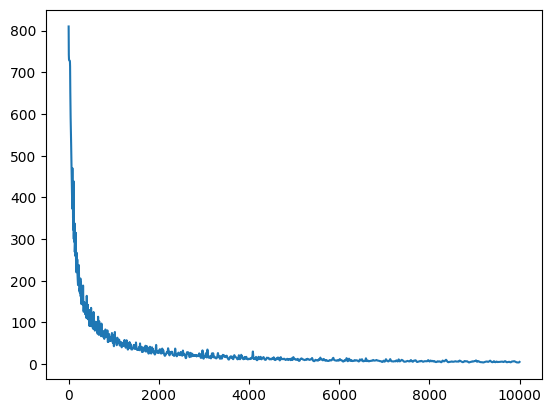

In [33]:
plt.plot(lossi)
plt.show()

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [34]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [35]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [36]:
X_tr.shape, Y_tr.shape, X_test.shape, Y_test.shape

(torch.Size([1000, 784]),
 torch.Size([1000, 10]),
 torch.Size([1000, 784]),
 torch.Size([1000, 10]))

In [37]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(n_in, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_out),
            nn.Tanh()
        ))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [38]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.11861	accuracy (train, test): 0.14400	0.29200
step =   1000	loss=0.00022	accuracy (train, test): 1.00000	0.88000
step =   2000	loss=0.00002	accuracy (train, test): 1.00000	0.87500
step =   3000	loss=0.00002	accuracy (train, test): 1.00000	0.87800
step =   4000	loss=0.00002	accuracy (train, test): 1.00000	0.87400
step =   5000	loss=0.00006	accuracy (train, test): 1.00000	0.87500
step =   6000	loss=0.00007	accuracy (train, test): 1.00000	0.87500
step =   7000	loss=0.00003	accuracy (train, test): 1.00000	0.87900
step =   8000	loss=0.00006	accuracy (train, test): 1.00000	0.87800
step =   9000	loss=0.00007	accuracy (train, test): 1.00000	0.87700


##### Exercise: try to improve accuracy!

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

n_in = 784
n_hidden = 200
n_out = 10

X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

# convert to onehot
Y_tr_cls = Y_tr.argmax(dim=1)
Y_test_cls = Y_test.argmax(dim=1)

class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(), # use Relu instead
            nn.Dropout(0.2),     # add regulization
            nn.Linear(n_hidden, n_out)
        )

    def forward(self, x):
        return self.layers(x)


model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss() # use crossentroy instead

# work wiht minibacth
batch_size = 128

train_dataset = TensorDataset(X_tr, Y_tr_cls)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)


num_epochs = 1000

for epoch in range(num_epochs):

    model.train()

    for xb, yb in train_loader:

        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():

        train_preds = model(X_tr)
        test_preds = model(X_test)

        train_acc = (train_preds.argmax(dim=1) == Y_tr_cls).float().mean()
        test_acc = (test_preds.argmax(dim=1) == Y_test_cls).float().mean()

    if epoch % 100 == 0:
        print(f"epoch={epoch:2d}  train_acc={train_acc:.4f}  test_acc={test_acc:.4f}")


epoch= 0  train_acc=0.7670  test_acc=0.6700
epoch=100  train_acc=1.0000  test_acc=0.8690
epoch=200  train_acc=1.0000  test_acc=0.8700
epoch=300  train_acc=1.0000  test_acc=0.8690
epoch=400  train_acc=1.0000  test_acc=0.8770
epoch=500  train_acc=1.0000  test_acc=0.8830
epoch=600  train_acc=1.0000  test_acc=0.8780
epoch=700  train_acc=1.0000  test_acc=0.8800
epoch=800  train_acc=1.0000  test_acc=0.8800
epoch=900  train_acc=1.0000  test_acc=0.8880
